In [12]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import brewer2mpl
from mitgcmdata import MITgcmmodel
from MITgcmutils import mds
from jmd95 import eos
from pygamman import gamman
import os

%matplotlib inline


In [20]:
# make a T/S diagram of gamma_n and sigma 0

n = 200
T = np.linspace(-2,12,n)
S = np.linspace(34.8, 33.5, n)
SS, TT = np.meshgrid(S,T)

lon = 0.
lat = -60.
PP = np.zeros_like(SS)
PP2 = 2000*np.ones_like(SS)

N = len(T)*len(S)

# surface sigma0
gn, dg_lo, dg_hi = gamman.gamma_n(SS.ravel(), TT.ravel(), PP.ravel(), N, lon, lat )
gn.shape = SS.shape
gn = np.ma.masked_less(gn, 0.)

# interior sigma2
gn2, _, _ = gamman.gamma_n(SS.ravel(), TT.ravel(), PP2.ravel(), N, lon, -30 )
gn2.shape = SS.shape
gn2 = np.ma.masked_less(gn2, 0.)


sig02d, _, _ = eos.state_surface(TT, SS)
sig22d, _, _ = eos.state(2000, TT, SS)

In [4]:
#ddir = '/glade/scratch/rpa/SOSE/run_matt'
ddir = '/data/scratch/rpa/SOSE/run_matt'

m = MITgcmmodel.ModelInstance(output_dir=ddir)


2160 320  42


/home/rpa/mitgcmdata/mitgcmdata/MITgcmmodel.py:75: RuntimeWarning: divide by zero encountered in reciprocal
  (self.rac * self.drf * self.hFacC)**-1, 0.)


## data.diagnostics ##

    frequency(1) = 2629200.0,
    fields(1,1) = 'SIarea  ',
                 'SIheff  ',
                 'SIhsnow ',
                 'SItflux ',
                 'SIatmQnt',
                 'SIempmr ',
                 'SIatmFW ',
                 'SIuheff ',
                 'SIvheff ',
                 'TFLUX   ',
                 'SFLUX   ',
                 'THETA   ',
                 'SALT    ',
    levels(1,1) = 1,
    filename(1) = 'DiagIce-monthly',




In [5]:
nrec = 0
new_ddir = '/data/scratch/rpa/SOSE/matt_iter100'


# 5 day output; want to sample different seasons
Nt = 438
# once every season for six years
recs = np.arange(0,Nt,18)

gamma = mds.rdmds(os.path.join(new_ddir, 'GAMMA.0000000100'), rec=recs, usememmap=True)
theta = mds.rdmds(os.path.join(new_ddir, 'THETA.0000000100'), rec=recs, usememmap=True)
salt = mds.rdmds(os.path.join(new_ddir, 'SALT.0000000100'), rec=recs, usememmap=True)

In [7]:
sig0, _, _ = eos.state_surface(theta.ravel(), salt.ravel())
sig0.shape = theta.shape

In [8]:
sig2, _, _ = eos.state(2000, theta.ravel(), salt.ravel())
sig2.shape = theta.shape

In [11]:
# mask
gmask = (gamma<0) | m.mask
sigma0 = np.ma.masked_array(sig0-1000, gmask)
sigma2 = np.ma.masked_array(sig2-1000, gmask)
gamma_n = np.ma.masked_array(gamma,gmask)
vol = np.ma.masked_array(m.rac * m.hFacC * m.drf * (~gmask), gmask)

In [45]:
def calc_sig_vs_gamma(sigma0, gamman, weight, sigma_bins, klim=None, mincount=4e9):
    a = sigma0[:,:klim].compressed()
    b = gamman[:,:klim].compressed()
    w = weight[:,:klim].compressed()
    
    Npts = len(sigma_bins)
    sigma_center = 0.5*(sigma_bins[1:] + sigma_bins[:-1])
    bin_idx = np.digitize(a, sigma_bins)
    
    count = np.ma.masked_less(
                np.bincount(bin_idx, weights=w, minlength=Npts+1),
                mincount).astype('f8')
    gamma_binned = np.bincount(bin_idx, weights=w*b, minlength=Npts+1) / count
    gamma_approx = np.interp(a, sigma_center, gamma_binned[1:-1], left=np.nan, right=np.nan)
    gamma_rmse = np.sqrt(np.bincount(bin_idx, weights=w*(b - gamma_approx)**2, minlength=Npts+1) / count)
    
    return sigma_center, gamma_binned, gamma_rmse

In [35]:
sigma_bins = np.linspace(25.8,28,300)
sig0_bins = np.linspace(22,28,500)
sig2_bins = np.linspace(30,37.7,500)

In [27]:
klim = 19
print 'Calculating gamma fit to depth', m.zf[klim]
sc, gb, ge = calc_sig_vs_gamma(sigma0, gamman, vol, sigma_bins, klim=20)

Calculating gamma fit to depth -671.0


NameError: name 'calc_sig_vs_gamma' is not defined

In [9]:
sc0, gb0, ge0 = calc_sig_vs_gamma(sigma0, gamma_n, vol, sigma_bins, klim=1)

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


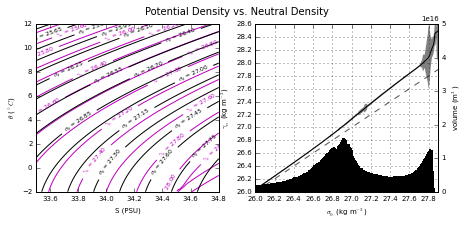

In [15]:
imax = 290

plt.rcParams['font.size'] = 7
plt.figure(figsize=(6.5,3))
plt.subplots_adjust(left=0.07, right=0.93, hspace=0.1)

ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2)
cgn = plt.contour(SS, TT, gn, 20, colors='m', label=r'$\sigma_\theta$')
csg = plt.contour(SS, TT, sig02d-1000, 20, colors='k', label=r'$\gamma_n$')
#plt.legend(loc='lower left')
plt.xlabel('S (PSU)')
plt.ylabel(r'$\theta$ ($^\circ C$)')

plt.clabel(csg, fmt=r'$\sigma_{\theta}$ = %3.2f', fontsize=6)
plt.clabel(cgn, fmt=r'$\gamma_n$ = %3.2f', fontsize=6)

ax = plt.subplot2grid((2,2), (0,1), rowspan=2)
ax.plot(sc[:imax], sc[:imax], '--', color='0.33')
#ax.errorbar(sc[:imax], gb[1:-1][:imax], ge[1:-1][:imax], colors='k')
ax.plot(sc[:imax], gb[1:-1][:imax], 'k')
ax.fill_between(sc[:imax], gb[1:-1][:imax] + ge[1:-1][:imax],
                           gb[1:-1][:imax] - ge[1:-1][:imax],
                 facecolor='0.5', edgecolor='none')

plt.grid()
plt.xticks(np.arange(26,29,0.2));
plt.yticks(np.arange(26,29,0.2));
plt.xlim([26,27.9])
plt.ylim([26,28.6])
plt.xlabel(r'$\sigma_0$ (kg m$^{-3}$)')
plt.ylabel(r'$\gamma_n$ (kg m$^{-3}$)')

ax2 = ax.twinx()
ax2.hist(sigma0[:,:klim].compressed(),
         bins=sigma_bins,
         weights=vol[:,:klim].compressed());
ax2.set_ylim([0,5e16])
ax2.set_xlim([26,27.9])
ax2.set_ylabel('volume (m$^3$)')

plt.suptitle('Potential Density vs. Neutral Density', fontsize=10)
plt.savefig('../figures_ice_moc/potential_vs_neutral_density_fit.pdf')

In [ ]:
type(gb[1:-1][:imax])

In [ ]:
imax = 290
np.savez('sigma_vs_gamma_SOSE_fit_upper670m',
         sigma0=sc[:imax],
         gamman=gb[1:-1][:imax].filled(np.nan),
         gamman_std=ge[1:-1][:imax].filled(np.nan))

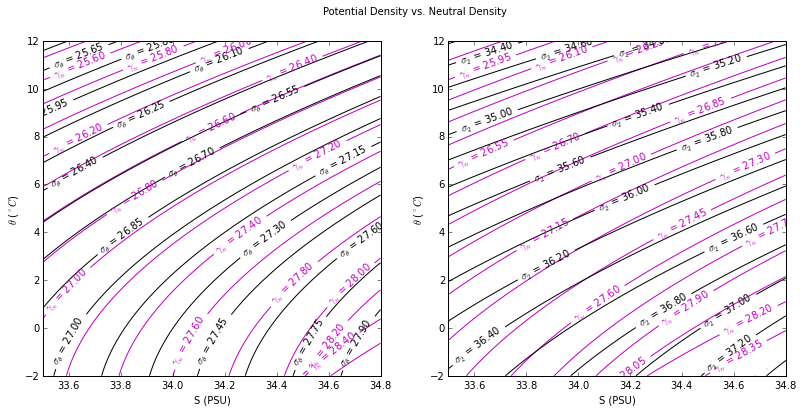

In [24]:
imax = 290

plt.rcParams['font.size'] = 10
plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.07, right=0.93, hspace=0.1)

#ax1 = plt.subplot2grid((2,2), (0,0), rowspan=2)
ax1 = plt.subplot(121)
cgn = plt.contour(SS, TT, gn, 20, colors='m', label=r'$\sigma_\theta$')
csg = plt.contour(SS, TT, sig02d-1000, 20, colors='k', label=r'$\gamma_n$')
#plt.legend(loc='lower left')
plt.xlabel('S (PSU)')
plt.ylabel(r'$\theta$ ($^\circ C$)')
plt.clabel(csg, fmt=r'$\sigma_{\theta}$ = %3.2f', fontsize=10)
plt.clabel(cgn, fmt=r'$\gamma_n$ = %3.2f', fontsize=10)

ax2 = plt.subplot(122)
cgn = plt.contour(SS, TT, gn2, 20, colors='m', label=r'$\sigma_\theta$')
csg = plt.contour(SS, TT, sig22d-1000, 20, colors='k', label=r'$\gamma_n$')
#plt.legend(loc='lower left')
plt.xlabel('S (PSU)')
plt.ylabel(r'$\theta$ ($^\circ C$)')
plt.clabel(csg, fmt=r'$\sigma_2$ = %3.2f', fontsize=10)
plt.clabel(cgn, fmt=r'$\gamma_n$ = %3.2f', fontsize=10)


plt.suptitle('Potential Density vs. Neutral Density', fontsize=10)
#plt.savefig('../figures_ice_moc/potential_vs_neutral_density_fit.pdf')

In [ ]:
# now build the linear interpolation
gamma_approx = np.interp(a, sigma_center, gamma_binned[1:-1], left=np.nan, right=np.nan)

In [ ]:
# this is wrong--have to subtract the bin mean of neutral density!
gamma_rmse = np.sqrt(np.bincount(bin_idx, weights=weight*(b - gamma_approx)**2, minlength=Npts+1) / count)

In [ ]:
plt.errorbar(sigma_center, gamma_binned[1:-1], yerr=gamma_rmse[1:-1], color='k')
plt.grid()
plt.xticks(np.arange(26,29,0.2));
plt.yticks(np.arange(26,29,0.2));
plt.xlim([26,28.2])
plt.ylim([26,29])


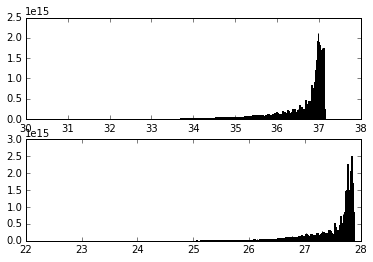

In [40]:
# histograms at 30S
jlev = 287
plt.subplot(211)
plt.hist(sigma2[...,jlev,:].compressed(),
         bins=sig2_bins,
         weights=vol[...,jlev,:].compressed());
plt.subplot(212)
plt.hist(sigma0[...,jlev,:].compressed(),
         bins=sig0_bins,
         weights=vol[...,jlev,:].compressed());

In [54]:
sc0, gb0, ge0 = calc_sig_vs_gamma(sigma0[...,jlev,:], gamma_n[...,jlev,:], vol[...,jlev,:], sig0_bins, klim=42)
sc2, gb2, ge2 = calc_sig_vs_gamma(sigma2[...,jlev,:], gamma_n[...,jlev,:], vol[...,jlev,:], sig2_bins, klim=42)


-c:13: RuntimeWarning: invalid value encountered in divide
-c:15: RuntimeWarning: invalid value encountered in divide


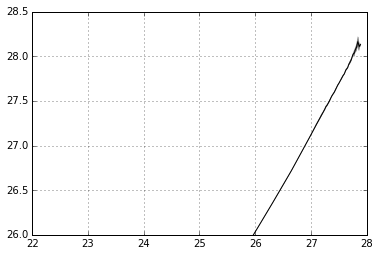

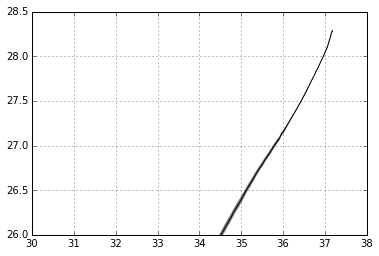

In [60]:
fig, ax = plt.subplots()
ax.plot(sc0, gb0[1:-1], 'k')
ax.fill_between(sc0, gb0[1:-1] + ge0[1:-1],
                           gb0[1:-1] - ge0[1:-1],
                 facecolor='0.5', edgecolor='none')
ax.set_ylim([26,28.5])
ax.grid()

fig, ax = plt.subplots()
ax.plot(sc2, gb2[1:-1], 'k')
ax.fill_between(sc2, gb2[1:-1] + ge2[1:-1],
                           gb2[1:-1] - ge2[1:-1],
                 facecolor='0.5', edgecolor='none')
ax.set_ylim([26,28.5])
ax.grid()

In [61]:
np.savez('sigma0_vs_gamma_SOSE_30S',
         sigma0=sc0,
         gamman=gb0[1:-1].filled(np.nan),
         gamman_std=ge0[1:-1].filled(np.nan))

np.savez('sigma2_vs_gamma_SOSE_30S',
         sigma0=sc2[:imax],
         gamman=gb2[1:-1][:imax].filled(np.nan),
         gamman_std=ge2[1:-1][:imax].filled(np.nan))